# Rotational Partition Function

The following plots the rotational partition function and how each quantum number, $J$, contributions. We use `ipywidgets` to add an interactive slider to control the temperature.
The manual for `ipywidgets` can be found [here](https://ipywidgets.readthedocs.io/en/latest/index.html).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 6.0]})
from scipy.constants import h, c, k, N_A
from scipy.misc import derivative 

In [2]:
B = 10.591 * 100         # 1/m # rotational wave-number (related to moment of inertia)
J = np.arange(0, 15, 1)  # quantum numbers (called "l" in Dill's book)

def q(J, beta):
    ''' rotational partition function for a given J '''
    return (2 * J + 1) * np.exp( -beta * h * c * B * J * (J + 1) )

def qrot(beta):
    ''' partition function for "inifinite" number of quantum numbers '''
    J = np.arange(0, 500, 1)
    return np.sum( q(J, beta) )

def qrotHT(beta):
    ''' partition function in the high temperature limit, i.e. summation --> integral '''
    return 1 / (beta * h * c * B)

def plot(T):
    ''' plots partition function at given temperature '''
    beta = 1 / (k * T)
    
    avg_energy = -derivative( qrot, beta, dx = 0.001*beta ) / qrot(beta) * beta
    plt.plot(J, q(J, beta).cumsum(), 'b--o', alpha = 0.7, lw = 2, ms = 10,
             label=r'Explicit summation <$E$>={:.2f} kT'.format(avg_energy))
    
    plt.plot([0,1000], [qrotHT(beta),qrotHT(beta)], 'r-', alpha = 0.5, lw = 4,
             label=r'High temperature limit <$E$>=1.00 kT')
    
    plt.title('Rotational Partition Function, $q_r$')
    plt.xlabel('Quantum number, $J$')
    plt.ylabel('Summed partition function, $q$')
    plt.xlim(0, 14)
    plt.legend(loc = 0, frameon = False)

# this part sets up a temperature slider to control the plot
i = interact(plot, T = (50, 1000), continuous_update = False)
i.widget.children[0].description=r'$T$ (Kelvin)';

interactive(children=(IntSlider(value=525, description='T', max=1000, min=50), Output()), _dom_classes=('widge…

## Vibrational Partition Function

The exact vibrational partition function can be written as (see Dill Eq. 11.26):
$$
q_v = \frac{1}{1 - e^{-\theta_v/T}}
$$

where $\theta_v$ is the _vibrational temperature_.
The average energy is obtained by taking the derivative with respect to $T$, or if you prefer, $\beta$:
$$
\langle \epsilon \rangle = \frac{U}{N} = kT^2 \left( {\frac{\partial \ln q}{\partial T}} \right )
= -\left ( \frac{\partial \ln q }{\partial \beta} \right )
$$
See e.g. Dill and Bromberg, 2nd edition, Eq. 10.33.
The contribution to the heat capacity _per_ particle is
$$
c_v = \frac{C_v}{N} = \frac{\partial \langle \epsilon \rangle}{\partial T}
$$
In the high temperature limit (which is normally invalid for chemical bonds), each vibrational mode contributes with one $k_B$ to the heat capacity. This is because a classical, oscillating spring has two quadratic terms from potential and kinetic energy, respectively.

In [3]:
def cv_vib_numeric(T, theta):
    '''
    Contribution to the heat capacity per molecule due to vibration (units of kB)
    This is the *lazy* way using Numpy's numerical differentiation function `np.gradient`.
    '''
    dT = T[1] - T[0]                                    # Temperature spacing
    q_vib = 1 / ( 1 - np.exp(-theta / T) )              # Exact partition function, q(T), see Dill Eq. 11.6
    energy = k * T**2 * np.gradient( np.log(q_vib), dT) # Average energy per particle,〈ε〉(units of Joules)
    return np.gradient(energy, dT) / k                  # Heat capacity (units of kB)

def cv_vib_analytic(T, theta):
    '''
    Contribution to the heat capacity per molecule due to vibration (units of kB)
    This is the analytic expression from double differentiation of the partition function
    '''
    return (theta / T)**2 * np.exp(theta / T) / (np.exp(theta / T) - 1)**2

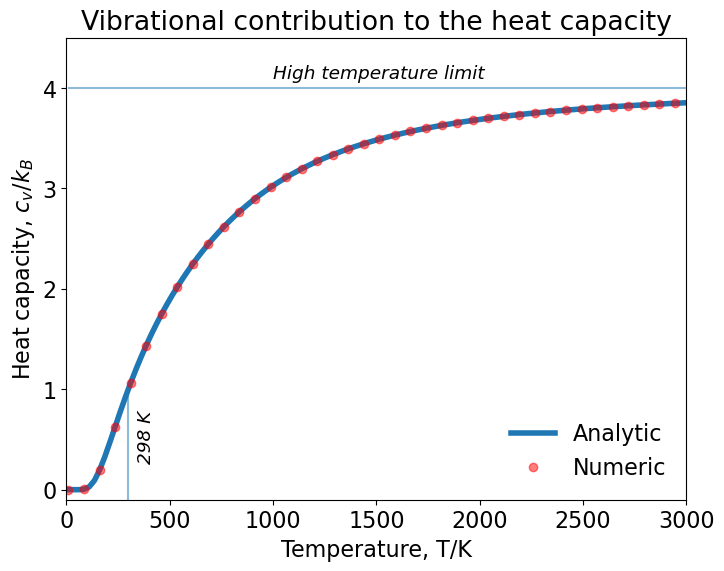

In [4]:
theta_range = [3360, 1890, 945, 945] # Vibrational temperatures (K)
T = np.linspace(10, 5000, 200) # Temperature interval (K)

# Sum contributions from several vibrational modes
cv_numeric = 0
cv_analytic = 0
for theta in theta_range:
    cv_numeric += cv_vib_numeric(T, theta)
    cv_analytic += cv_vib_analytic(T, theta)

plt.title('Vibrational contribution to the heat capacity')
plt.xlabel('Temperature, T/K')
plt.ylabel('Heat capacity, $c_v/k_B$')
plt.text(1000, 4.1, 'High temperature limit', fontsize = 'small', style = 'italic')
plt.text(340, 0.3, '298 K', fontsize = 'small', style = 'italic', rotation = 90)
plt.hlines(4, T.min(), T.max(), alpha = 0.5)
plt.vlines(298, -1, 1, alpha=0.5)
plt.plot(T, cv_analytic, alpha = 1.0, lw = 4, label = 'Analytic')
plt.plot(T, cv_numeric, 'ro', alpha = 0.5, label = 'Numeric', markevery = 3)
plt.xlim(0, 3000)
plt.ylim(-0.1, 4.5)
plt.legend(loc = 4, frameon = False)
plt.show()

### Symbolic derivation using SymPy

Here we use symbolic differentiation using SymPy and obtain the same expression as used in the analytical solution above.
We also investigate $\lim_{T\rightarrow \infty} c_v(T)$ and show that it we indeed get $k_B$ as expected.

In [5]:
from sympy import *
T, theta, k_B = symbols("T theta k_B", real = True, positive = True)
q             = 1 / (1 - exp(-theta / T))
mean_energy   = k_B * T**2 * diff( ln(q), T ) 
cv            = factor( diff( mean_energy, T ) )
cv

k_B*theta**2*exp(theta/T)/(T**2*(exp(theta/T) - 1)**2)

In [6]:
limit(cv, T, oo) # "oo" = infinity

k_B